Modelo híbrido: Regresión Lineal + MLP
===

## Objetivos de aprendizaje
- Describir el modelo matemático, la operación y los casos de uso de un perceptrón multicapa
- Implementar un perceptrón multicapa a través de Scikitlearn y TensorFlow
- Aplicar la red implementada a un caso de regresión no lineal

## Definición del problema real

Se desea construir un modelo de regresión no lineal para la siguiente muestra de 31 observaciones de $(x, y)$. 

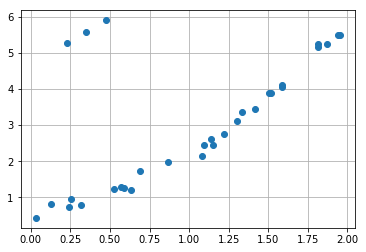

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [1.8131, 0.0318, 1.5181, 0.2522, 0.2440, 1.4175, 
     1.9538, 1.1506, 1.5042, 1.0798, 1.0915, 0.3173, 
     1.8157, 1.3352, 1.1399, 0.1276, 0.6909, 0.6331, 
     0.8671, 0.5867, 1.9373, 1.5842, 0.5707, 0.5285, 
     1.8708, 1.5870, 1.3027, 1.2181, 0.2318, 0.3471, 
     0.4763]

d = [5.1568, 0.4351, 3.8980, 0.9654, 0.7383, 3.4500, 
     5.4851, 2.4401, 3.8941, 2.1366, 2.4431, 0.8058, 
     5.2531, 3.3671, 2.6199, 0.8230, 1.7403, 1.2172, 
     1.9868, 1.2564, 5.4922, 4.0645, 1.2978, 1.2245, 
     5.2532, 4.1206, 3.1076, 2.7601, 5.2678, 5.5783, 
     5.8991]

plt.plot(x, d, 'o')
plt.grid()

## Definición del problema en términos de los datos

Se desea construir un modelo no lineal que relacione las variables $x$ y $y$.

## Metodología 

### Modelo matemático

Muchos modelos nuevos pueden ser obtenidos por la combinación de modelos estadísticos y diferentes tipos de redes neuronales. En este caso, se usará un modelo llamaado ARNN (autoregressive Neuranl Nertwork) que es proveniente de la literatura de series de tiempo. En esta aplicación seria más apropiado llamarlo regresión + MLP.

El modelo general de regresión lineal puede especificarse como:

$$y_t = \phi^* + \sum_i \phi_i x_i +e_i$$

donde $e_i$ es el término de error. Este modelo puede ser representado como un percpetrón con función de activación igual a la función de identidad.

![assets/MulticapaLR.png](assets/MulticapaLR.png)

Por otra parte, un perceptrón multicapa con una capa oculta y que usa las funciones $\sigma(\cdot)$ para la activación de las capas oculta e identidad para la salida, puede especificarse como:

$$y_t = \phi^* + \sum_{h} \beta_h \cdot \sigma \left(w^*_h + \sum_{i} w_{i,h} x_i \right) $$


![assets/MulticapaMLP.png](assets/MulticapaMLP.png)

En el modelo regresión+MLP, la especificación sería:

$$y_t = \phi^* + \sum_i \phi_i x_i +  \sum_{h} \beta_h \cdot \sigma \left(w_h + \sum_{i} w_{i,h} x_i \right)  + e_i$$

donde todos los parámetros serían estimados simultáneamente mediante la minimización del error.


### Implementación

#### Solución usando regresión lineal

SSE =  23.203339


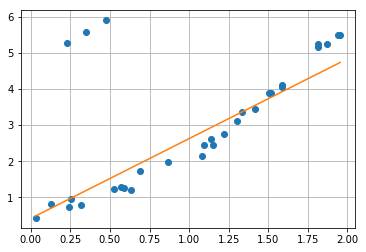

In [2]:
##
##  Preparación
##
import tensorflow as tf
import numpy as np

##
##  Datos
##
X_ = tf.constant(x)
d_ = tf.constant(d)

##
## Info pronostico
##
Xpred = np.linspace(np.min(x), np.max(x), 50, dtype=np.float32)
Xpred_ = tf.constant(Xpred)

## parámetros
w0 = tf.Variable(0.0)
w1 = tf.Variable(1.0)

## Define el modelo de regresión lineal
m = tf.add(tf.multiply(X_, w1), w0)

## Define la función de error
# SSE = tf.reduce_sum(tf.square(d_ - m)) # sum of the squared errors
SSE = tf.reduce_sum(tf.abs(d_ - m)) # sum of the squared errors

## Inicializa el optimizador
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(SSE)

## Pronostico
ypred = tf.add(tf.multiply(Xpred_, w1), w0)

## estima el modelo
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        sess.run(optimizer)
    p = sess.run(ypred)
    e = sess.run(SSE)    

print('SSE = ', e)
plt.plot(x, d, 'o')
plt.plot(Xpred, p, '-')
plt.grid()

**Actividad.--** Compare el ajuste cuando usa la función SSE y cuando computa la suma de errores absolutos.

#### Solución usando un MLP con activación lineal a la salida

SSE =  49.13365


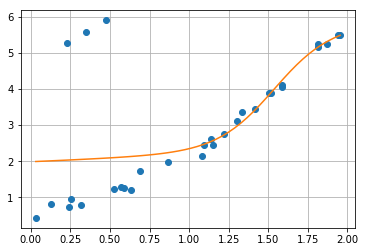

In [3]:
%clear
##
## Parametros
##
H = 3
learning_rate=0.01
max_iter=10000

##
## Datos
##
X = [[u] for u in x]
N = len(X[0])
P = len(X)

X_ = tf.constant(X, dtype=np.float32)
d_ = tf.constant(d, dtype=np.float32, shape=[len(d), 1])
    
##
## Info pronostico
##
Xpred = np.linspace(np.min(x), np.max(x), 50, dtype=np.float32)
Xpred = [[u] for u in Xpred]
Xpred_ = tf.constant(Xpred)

 
##
## Parámetros
##
intercept = tf.Variable(0.1 * np.mean(d),            dtype=np.float32)
WHOparams = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)
WIHparams = tf.Variable(0.1 * np.random.randn(N, H), dtype=np.float32)
BHparams  = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)

##
## Propagación de la señal
##
In_hidden = tf.add(tf.matmul(X_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [P, 1]))
Out_hidden = tf.sigmoid(In_hidden)        
MLP_output = tf.matmul(Out_hidden, WHOparams)
model_output = tf.add(intercept, MLP_output)

##
## Función de error
##
SSE = tf.reduce_sum(tf.square(d_ - model_output)) # sum of the squared errors
#SSE = tf.reduce_sum(tf.abs(d_ - model_output)) # sum of the squared errors

##
## Optimizador
##
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(SSE)

##
## Pronostico
##
In_hidden = tf.add(tf.matmul(Xpred_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [len(Xpred), 1]))
Out_hidden = tf.sigmoid(In_hidden)        
MLP_output = tf.matmul(Out_hidden, WHOparams)
ypred = tf.add(intercept, MLP_output)

##
## Ejecución 
##
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_iter):
        sess.run(optimizer)
    p = sess.run(ypred)
    e = sess.run(SSE) 

print('SSE = ', e)
plt.plot(x, d, 'o')
plt.plot(Xpred, p, '-')
plt.grid()

**Actividad.--** Compare el ajuste cuando usa la función SSE y cuando computa la suma de errores absolutos para distintos  valores de $H$.

### Solución usando un LR+MLP

SSE =  23.17302


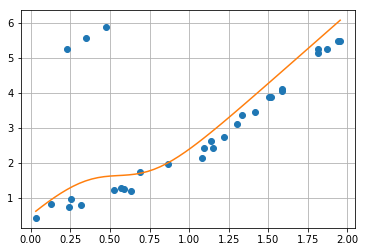

In [4]:
%clear
##
## Parametros
##
H = 3
learning_rate=0.01
max_iter=10000

##
## Datos
##
X = [[u] for u in x]
N = len(X[0])
P = len(X)

X_ = tf.constant(X, dtype=np.float32)
d_ = tf.constant(d, dtype=np.float32, shape=[len(d), 1])
    
##
## Info pronostico
##
Xpred = np.linspace(np.min(x), np.max(x), 50, dtype=np.float32)
Xpred = [[u] for u in Xpred]
Xpred_ = tf.constant(Xpred)

##
## Parámetros
##
intercept = tf.Variable(0.1 * np.mean(d),            dtype=np.float32)
LRparams  = tf.Variable(0.1 * np.random.randn(N, 1), dtype=np.float32)
WHOparams = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)
WIHparams = tf.Variable(0.1 * np.random.randn(N, H), dtype=np.float32)
BHparams  = tf.Variable(0.1 * np.random.randn(H, 1), dtype=np.float32)

##
## Propagación de la señal
##
LR_output = tf.matmul(X_, LRparams)
LR_output = tf.add(intercept, LR_output)
In_hidden = tf.add(tf.matmul(X_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [P, 1]))
Out_hidden = tf.sigmoid(In_hidden)        
MLP_output = tf.matmul(Out_hidden, WHOparams)
model_output = tf.add(LR_output, MLP_output)

##
## Función de error
##

# SSE = tf.reduce_sum(tf.square(d_ - model_output)) # sum of the squared errors
SSE = tf.reduce_sum(tf.abs(d_ - model_output)) # sum of the squared errors

##
## Optimizador
##
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(SSE)

##
## Pronostico
##
LR_output = tf.matmul(Xpred_, LRparams)
LR_output = tf.add(intercept, LR_output)
In_hidden = tf.add(tf.matmul(Xpred_, WIHparams),
                   tf.tile(tf.transpose(BHparams), [len(Xpred), 1]))
Out_hidden = tf.sigmoid(In_hidden)        
MLP_output = tf.matmul(Out_hidden, WHOparams)
ypred = tf.add(LR_output, MLP_output)



##
## Ejecución 
##
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(max_iter):
        sess.run(optimizer)
    p = sess.run(ypred)
    e = sess.run(SSE) 

print('SSE = ', e)
plt.plot(x, d, 'o')
plt.plot(Xpred, p, '-')
plt.grid()

**Actividad.--** Compare el ajuste cuando usa la función SSE y cuando computa la suma de errores absolutos para distintos  valores de $H$.